In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.5.1+cu121'

In [3]:
torchvision.__version__

'0.20.1+cu121'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
!nvidia-smi

Thu Jul 31 22:28:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              7W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [8]:
batch_size = 128
epochs = 10
lr = 3e-4
patch_size = 4 ## segment images into patches of 4*4
num_classes = 10
im_size = 32
channels = 3
emb_dim = 256
num_heads = 8
num_blocks = 6
mlp_dim = 512
drop_rate = 0.1

Image Transformation

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
    transforms.ToTensor() ,
    transforms.Normalize((0.5),(0.5)) ## for numerical stability
])

In [10]:
transform = transforms.Compose([
    transforms.ToTensor() , transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ## for numerical stability
])

In [11]:
train_dataset = datasets.CIFAR10(root = "./data",train = True,download = True,transform = transform)
test_dataset  = datasets.CIFAR10(root = "./data",train = False,download = True,transform = transform)

100%|██████████| 170M/170M [00:59<00:00, 2.85MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
test_loader  = DataLoader(test_dataset,batch_size = batch_size,shuffle = False)

In [13]:
print(f"Data Loaders : {train_loader,test_loader}")
print(f'Train Data   : {len(train_loader)} batches of size 128')
print(f'Test Data    : {len(test_loader)}  batches of size 128')

Data Loaders : (<torch.utils.data.dataloader.DataLoader object at 0x00000270EDFB7BF0>, <torch.utils.data.dataloader.DataLoader object at 0x00000270BF1D1EE0>)
Train Data   : 391 batches of size 128
Test Data    : 79  batches of size 128


In [14]:
class PatchEmbedding(nn.Module):
  def __init__(self,im_size,patch_size,channels,emb_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(channels,emb_dim,kernel_size=patch_size,stride=patch_size) ## for image segmentation into patches
    self.num_batches = (im_size // patch_size) ** 2
    self.cls_token   = nn.Parameter(torch.randn(1,1,emb_dim))
    self.pos_emb     = nn.Parameter(torch.randn(1,self.num_batches+1,emb_dim))
  def forward(self,x:torch.tensor):
    B = x.size(0) ## num of batches
    x = self.proj(x) ## (B,E,H//patch_size,W//patch_size)
    x = x.flatten(2).transpose(1,2) ## (B,H//patch_size * W//patch_size,E)
    cls_token = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_token,x),dim=1)
    x = x + self.pos_emb
    return x

In [15]:
class MLP(nn.Module) :
  def __init__(self,in_features,hidden_features,drop_rate) :
    super().__init__()
    self.linear_1 = nn.Linear(in_features,hidden_features)
    self.linear_2 = nn.Linear(hidden_features,in_features)
    self.drop = nn.Dropout(drop_rate)

  def forward(self,x) :
    x = self.linear_1(x)
    x = F.gelu(x)
    x = self.drop(x)
    x = self.linear_2(x)
    x = self.drop(x)

    return x

In [16]:
class TransformerEncoderLayer(nn.Module) :
  def __init__(self,emb_dim,num_heads,mlp_dim,drop_rate) :
    super().__init__()
    self.norm1 = nn.LayerNorm(emb_dim)
    self.attn = nn.MultiheadAttention(emb_dim,num_heads,dropout=drop_rate,batch_first=True)
    self.norm2 = nn.LayerNorm(emb_dim)
    self.mlp = MLP(emb_dim,mlp_dim,drop_rate)
  def forward(self,x) :
    x = x + self.attn(self.norm1(x),self.norm1(x),self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))

    return x

In [17]:
class VisionTransformer(nn.Module):
  def __init__(self,im_size,patch_size,in_channels,num_classes,emb_dim,num_blocks,num_heads,mlp_dim,drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(im_size,patch_size,in_channels,emb_dim)
    self.encoder = nn.Sequential(
                *[TransformerEncoderLayer(emb_dim, num_heads, mlp_dim, drop_rate) for _ in range(num_blocks)]
              )
    self.layer_norm = nn.LayerNorm(emb_dim)
    self.head = nn.Linear(emb_dim,num_classes)
  def forward(self,x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.layer_norm(x)
    cls_token = x[:,0]
    return self.head(cls_token)

In [18]:
model = VisionTransformer(im_size,patch_size,channels,num_classes,emb_dim,num_blocks,num_heads,mlp_dim,drop_rate).to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=lr)

In [20]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [21]:
def train(model,loader,optimizer,criterion) :
  model.train()
  total_loss , correct = 0,0
  for x,y in loader:
    x,y = x.to(device),y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out,y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y ).sum().item()
  return total_loss / len(loader.dataset) , correct / len(loader.dataset)

In [22]:
def evaluate(model,loader):
  model.eval()
  correct = 0
  with torch.no_grad() :
    for x,y in loader :
      x,y = x.to(device),y.to(device)
      out = model(x)
      correct += (out.argmax(1) == y ).sum().item()

  return correct / len(loader.dataset)

In [23]:
from tqdm.auto import tqdm

C:\Users\DHIA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
### Training
train_accuracy = []
test_accuracy = []
for epoch in tqdm(range(epochs)) :
  train_loss , train_acc = train(model,train_loader,optimizer,criterion)
  test_acc = evaluate(model,test_loader)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  print(f"Epoch {epoch+1}/{epochs} || train loss : {train_loss} , train accuracy : {train_acc} | test_accuracy : {test_acc}")

 10%|█         | 1/10 [00:58<08:47, 58.64s/it]

Epoch 1/10 || train loss : 1.7368004497909546 , train accuracy : 0.36964 | test_accuracy : 0.4636


 20%|██        | 2/10 [02:03<08:16, 62.02s/it]

Epoch 2/10 || train loss : 1.3816258225250244 , train accuracy : 0.50352 | test_accuracy : 0.546


 30%|███       | 3/10 [03:14<07:44, 66.43s/it]

Epoch 3/10 || train loss : 1.2335887851333618 , train accuracy : 0.55766 | test_accuracy : 0.5611


 40%|████      | 4/10 [04:28<06:54, 69.14s/it]

Epoch 4/10 || train loss : 1.1271689910507203 , train accuracy : 0.59592 | test_accuracy : 0.5879


 50%|█████     | 5/10 [05:41<05:53, 70.76s/it]

Epoch 5/10 || train loss : 1.0312116667175293 , train accuracy : 0.63346 | test_accuracy : 0.6046


 60%|██████    | 6/10 [06:49<04:38, 69.71s/it]

Epoch 6/10 || train loss : 0.961566266746521 , train accuracy : 0.65644 | test_accuracy : 0.6142


 70%|███████   | 7/10 [08:02<03:32, 70.97s/it]

Epoch 7/10 || train loss : 0.8838848099899292 , train accuracy : 0.68466 | test_accuracy : 0.6233


 80%|████████  | 8/10 [09:19<02:25, 72.88s/it]

Epoch 8/10 || train loss : 0.8137855823135376 , train accuracy : 0.70882 | test_accuracy : 0.6199


 90%|█████████ | 9/10 [10:41<01:15, 75.72s/it]

Epoch 9/10 || train loss : 0.7383066970062255 , train accuracy : 0.7394 | test_accuracy : 0.6302


100%|██████████| 10/10 [12:02<00:00, 72.30s/it]

Epoch 10/10 || train loss : 0.6678411931228637 , train accuracy : 0.7621 | test_accuracy : 0.6327


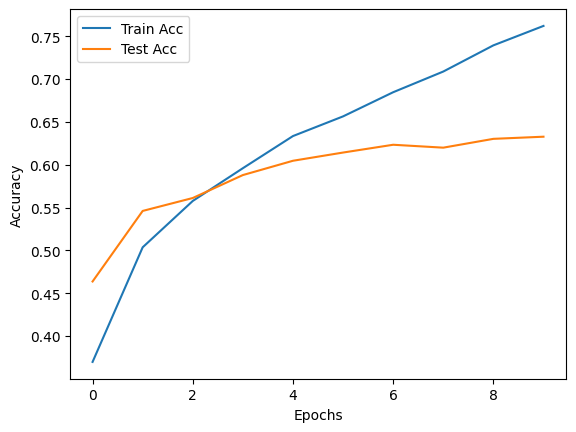

In [25]:
plt.plot(train_accuracy,label="Train Acc")
plt.plot(test_accuracy,label="Test Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
import random

In [28]:
def predict_and_plot(model,dataset,classes,grid_size=3):
  model.eval()
  fig,axes = plt.subplots(grid_size,grid_size,figsize=(9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx=random.randint(0,len(dataset)-1)
      img,true_label=dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.no_grad():
        output = model(input_tensor)
        _,predicted = torch.max(output.data,1)
      img =   img / 2 + 0.5
      npimg = img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg,(1,2,0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth :
        color = "g"
      else :
        color = "r"
      axes[i,j].set_title(f"Truth : {classes[true_label]}\n, predicted : {classes[predicted.item()]}",fontsize=10,c=color)
      axes[i,j].axis("off")
  plt.tight_layout()
  plt.show()

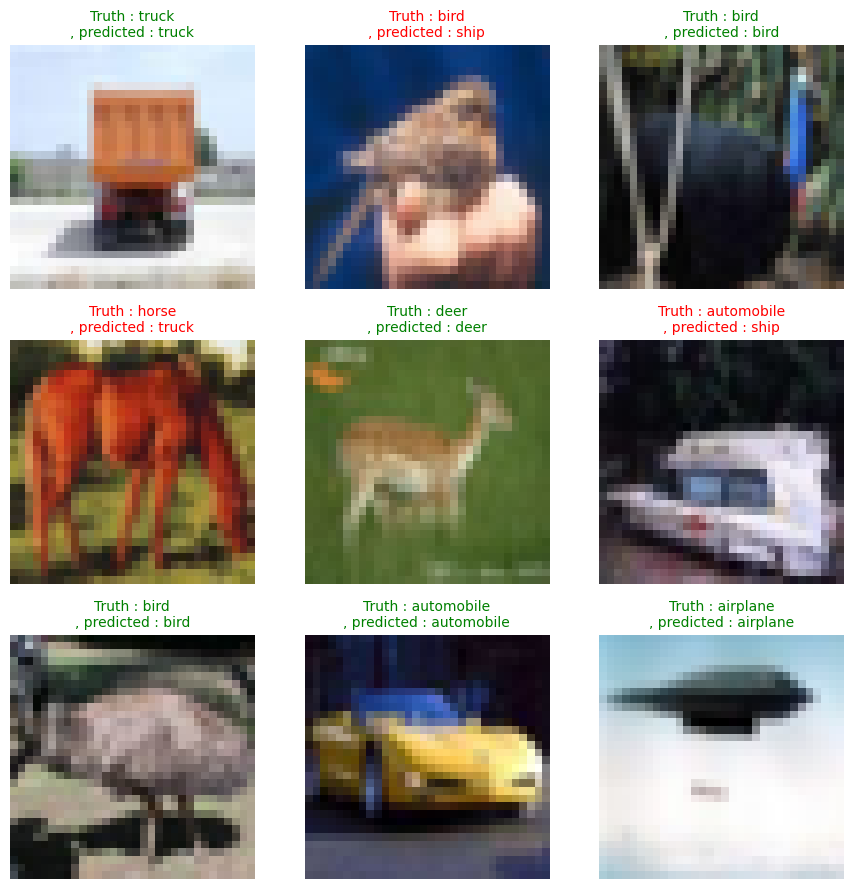

In [30]:
predict_and_plot(model,test_dataset,classes=train_dataset.classes,grid_size=3)

In [31]:
train_dataset = datasets.CIFAR10(root = "./data_new",train = True,download = True,transform = transform_train)
test_dataset  = datasets.CIFAR10(root = "./data_new",train = False,download = True,transform = transform_train)

100%|██████████| 170M/170M [00:52<00:00, 3.27MB/s] 


Extracting ./data_new\cifar-10-python.tar.gz to ./data_new
Files already downloaded and verified


In [32]:
train_loader_new = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
test_loader_new  = DataLoader(test_dataset,batch_size = batch_size,shuffle = False)

In [34]:
test_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [35]:
model_new = VisionTransformer(im_size,patch_size,channels,num_classes,emb_dim,num_blocks,num_heads,mlp_dim,drop_rate).to(device)

In [ ]:
train_accuracy = []
test_accuracy = []
print(f"hello")
for epoch in tqdm(range(epochs)) :
  train_loss , train_acc = train(model_new,train_loader_new,optimizer,criterion)
  test_acc = evaluate(model_new,test_loader_new)
  train_accuracy.append(train_acc)
  print(f"hello")
  test_accuracy.append(test_acc)
  print(f"Epoch {epoch+1}/{epochs} || train loss : {train_loss} , train accuracy : {train_acc} | test_accuracy : {test_acc}")

In [ ]:
plt.plot(train_accuracy,label="Train Acc")
plt.plot(test_accuracy,label="Test Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
predict_and_plot(model,test_dataset,classes=train_dataset.classes,grid_size=3)